# IMPORT LIBRARIES

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re

import yfinance as yf
import datetime

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from tqdm import tqdm

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, cross_val_predict, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

from math import sqrt
import random
random.seed(42)

# NECESSARY FUNTIONS

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
news_path = '/content/drive/MyDrive/[THESIS_2024] MARKET_PREDICTION/data/label_data.csv'
vn30f_path = '/content/drive/MyDrive/[THESIS_2024] MARKET_PREDICTION/data/VN30F1M.csv'
news = pd.read_csv(news_path, usecols=[1,5], parse_dates=['date'])
df = pd.read_csv(vn30f_path, usecols=[1,2,3,4,5,6], parse_dates=['Date'])

In [4]:
df

,Date,Open,High,Low,Close,Volume
0,2017-08-10 09:16:00,757.9,757.9,757.9,757.9,6.0
1,2017-08-10 09:19:00,757.0,757.0,757.0,757.0,4.0
2,2017-08-10 09:22:00,756.8,756.8,756.8,756.8,5.0
3,2017-08-10 09:25:00,756.2,756.2,756.2,756.2,6.0
4,2017-08-10 09:28:00,755.5,755.5,755.5,755.5,5.0
...,...,...,...,...,...,...
395492,2024-02-27 14:27:00,1240.9,1240.9,1239.8,1240.2,1331.0
395493,2024-02-27 14:28:00,1240.2,1240.4,1240.2,1240.4,815.0
395494,2024-02-27 14:29:00,1240.3,1242.0,1240.0,1241.5,2123.0
395495,2024-02-27 14:30:00,1242.5,1242.5,1242.5,1242.5,124.0


In [ ]:
df[df.Date.dt.year >= 2018]

,Date,Open,High,Low,Close,Volume
23239,2018-01-02 09:00:00,983.9,983.9,983.0,983.0,115.0
23240,2018-01-02 09:01:00,983.0,983.0,982.0,983.0,30.0
23241,2018-01-02 09:02:00,982.4,982.5,982.4,982.4,21.0
23242,2018-01-02 09:03:00,982.4,982.4,982.3,982.4,41.0
23243,2018-01-02 09:04:00,982.4,982.4,982.0,982.0,22.0
...,...,...,...,...,...,...
395492,2024-02-27 14:27:00,1240.9,1240.9,1239.8,1240.2,1331.0
395493,2024-02-27 14:28:00,1240.2,1240.4,1240.2,1240.4,815.0
395494,2024-02-27 14:29:00,1240.3,1242.0,1240.0,1241.5,2123.0
395495,2024-02-27 14:30:00,1242.5,1242.5,1242.5,1242.5,124.0


In [ ]:
# news = pd.read_csv(news_path, usecols = [1,2,3,4,5], parse_dates=['date'])
# news['date'] = pd.to_datetime(news['date'], format='%d-%m-%Y - %H:%M %p')
# news.set_index('date', inplace=True)
news[news.index.year >= 2018]

,title,description,content,result
date,,,,
2018-01-03 11:16:00,Công ty chứng khoán phát hành hàng nghìn tỷ đồ...,Trong bối cảnh lãi suất ngân hàng không mấy hấ...,Công ty chứng khoán phát hành hàng nghìn tỷ đồ...,3
2018-01-04 08:33:00,CTCK nhận định thị trường 04/01: Gia tăng tỷ t...,Sau khi vượt qua mốc kháng cự tâm lý 1000 điểm...,CTCK nhận định thị trường 04/01: Gia tăng tỷ t...,3
2018-01-04 08:00:00,CTCK BSC dự báo dòng tiền sẽ sớm dịch chuyển v...,Với một chu kỳ tăng giá mạnh thường nhóm cổ ph...,CTCK BSC dự báo dòng tiền sẽ sớm dịch chuyển v...,1
2018-01-12 08:36:00,CTCK nhận định thị trường 12/01: Cẩn trọng khi...,Nhiều khả năng các chỉ số chủ chốt sẽ có những...,CTCK nhận định thị trường 12/01: Cẩn trọng khi...,0
2018-01-15 17:00:00,Khối ngoại tiếp tục mua ròng hơn 700 tỷ trên t...,Chứng chỉ quỹ E1VFVN30 được khối ngoại mua ròn...,Khối ngoại tiếp tục mua ròng hơn 700 tỷ trên t...,1
...,...,...,...,...
2024-01-20 08:03:00,Thị phần chiếm hơn 1/5 toàn sàn và quá nửa thị...,Hoạt động môi giới và cho vay khởi sắc giúp lợ...,Thị phần chiếm hơn 1/5 toàn sàn và quá nửa thị...,1
2024-01-27 09:10:00,Hơn 200.000 tỷ đồng trái phiếu doanh nghiệp ri...,Trong hơn 200.000 tỷ đồng trái phiếu doanh ngh...,Hơn 200.000 tỷ đồng trái phiếu doanh nghiệp ri...,1
2024-02-02 20:44:00,Cổ phiếu ngân hàng bị bán mạnh,Chỉ số VN-Index hôm nay (2/2) vẫn tiến lên như...,Cổ phiếu ngân hàng bị bán mạnh Chỉ số VN-Index...,0


In [ ]:
# df.Date = pd.to_datetime(df.Date)
df1 = df[df.Date.dt.year >= 2018]
df1.groupby(df1.Date.dt.strftime('%Y-%m-%d')).count()

,Date,Open,High,Low,Close,Volume
Date,,,,,,
2018-01-02,243,243,243,243,243,243
2018-01-03,242,242,242,242,242,242
2018-01-04,242,242,242,242,242,242
2018-01-05,242,242,242,242,242,242
2018-01-08,243,243,243,243,243,243
...,...,...,...,...,...,...
2024-02-21,243,243,243,243,243,243
2024-02-22,243,243,243,243,243,243
2024-02-23,243,243,243,243,243,243


In [ ]:
def change_value(x):
    if x == 2:
        return 1
    elif x == 3:
        return 2
    else:
        return x

In [ ]:
news.result = news.result.apply(change_value)

([<matplotlib.patches.Wedge at 0x7de6fbb7a410>,
 [Text(0.12406603662667391, 1.0929810696236915, 'neutral'),
  Text(-0.6725845325297428, -0.8704194658908702, 'positive'),
  Text(0.9407244243089589, -0.5701206517120548, 'negative')])

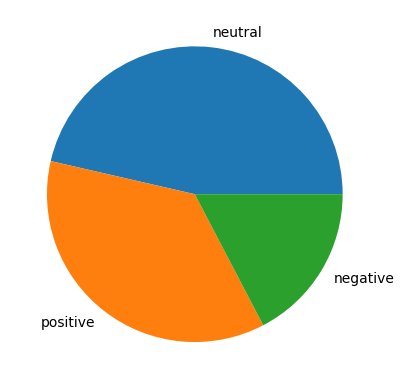

In [ ]:
result.value_counts().values
plt.pie(result.value_counts().values, labels = ['neutral', 'positive', 'negative'])

In [5]:
# read data
def read_data(news = False, vn30i = False):
    vn30f_path = '/content/drive/MyDrive/[THESIS_2024] MARKET_PREDICTION/data/VN30F1M.csv'
    news_path = '/content/drive/MyDrive/[THESIS_2024] MARKET_PREDICTION/data/label_data.csv'
    vn30i_path = '/content/drive/MyDrive/[THESIS_2024] MARKET_PREDICTION/data/VN30_index.csv'
    df = pd.read_csv(vn30f_path, usecols=[1,2,3,4,5,6], parse_dates=['Date'])

    if news:
        new = pd.read_csv(news_path, usecols=[1,5])
        new['date'] = pd.to_datetime(new['date'], format='%d-%m-%Y - %H:%M %p')
        new.set_index('date', inplace=True)
        new = new.resample('15T')['result'].mean().dropna()

    if vn30i:
        vn30i = pd.read_csv(vn30i_path, usecols=[1,2,3,4,5,6], parse_dates=['Date'])

    return df, new, vn30i

In [6]:
def resample(df, time_period):
    ohlc = {'Open':'first', 'High':'max', 'Low': 'min', 'Close': 'last', 'Volume':'sum'}

    df['Datetime'] = pd.to_datetime(df['Date'])
    df = df.sort_values(by='Datetime')

    df = df.resample(time_period, on='Datetime', label='right', closed='right').apply(ohlc)
    df.dropna(inplace=True)
    df['Date'] = df.index.date
    df['Date'] = df['Date'].apply(lambda x: x.strftime("%Y-%m-%d"))

    df['time'] = (df.index.time)
    df['time'] = df['time'].apply(lambda x: x.strftime('%H:%M:%S'))
    return df

In [7]:
def get_model_data(close_feature, close_index_feature, sp, time_enter, time_exit, target_threshold):
    minute_index = list(close_feature)

    enter_index = minute_index.index(time_enter)
    model_data = pd.DataFrame()
    model_data['trend_from_ato'] = close_feature[time_enter]/close_feature['09:15:00'] - 1
    model_data['gap'] = close_feature['09:15:00']/close_feature['14:45:00'].shift(1) - 1
    model_data['trend_open15'] = close_feature['09:30:00']/close_feature['09:15:00'] - 1
    model_data['trend_open30'] = close_feature['09:45:00']/close_feature['09:15:00'] - 1
    model_data['trend_open45'] = close_feature['10:00:00']/close_feature['09:15:00'] - 1
    model_data['trend_15m'] = close_feature[time_enter]/close_feature[minute_index[enter_index-1]] - 1
    model_data['trend_30m'] = close_feature[time_enter]/close_feature[minute_index[enter_index-2]] - 1
    model_data['trend_45m'] = close_feature[time_enter]/close_feature[minute_index[enter_index-3]] - 1
    model_data['trend_1d'] = close_feature[time_enter]/close_feature[time_enter].shift(1) - 1
    model_data['trend_2d'] = close_feature[time_enter]/close_feature[time_enter].shift(2) - 1
    model_data['trend_3d'] = close_feature[time_enter]/close_feature[time_enter].shift(3) - 1
    model_data['trend_1w'] = close_feature[time_enter]/close_feature[time_enter].shift(5) - 1
    model_data['trend_2w'] = close_feature[time_enter]/close_feature[time_enter].shift(10) - 1
    model_data['trend_3w'] = close_feature[time_enter]/close_feature[time_enter].shift(15) - 1
    model_data['trend_4w'] = close_feature[time_enter]/close_feature[time_enter].shift(20) - 1

    model_data['us_trend_day'] = sp['Close']/sp['Close'].shift(1) - 1
    model_data['us_trend_day'] = model_data['us_trend_day'].replace(0, np.nan).ffill()
    model_data['us_trend_day_l1'] = sp['Close'].shift(1)/sp['Close'].shift(2) - 1
    model_data['us_trend_day_l2'] = sp['Close'].shift(2)/sp['Close'].shift(3) - 1
    model_data['us_trend_week'] = sp['Close']/sp['Close'].shift(5) - 1

    model_data['index_trend_lday'] = close_index_feature[time_exit].shift(1)/close_index_feature[time_enter].shift(1) - 1
    model_data['index_trend_l2day'] = close_index_feature[time_exit].shift(2)/close_index_feature[time_enter].shift(2) - 1
    model_data['index_trend_from_ato'] = close_index_feature[time_enter]/close_index_feature['09:15:00'] - 1
    model_data['index_trend_1d'] = close_index_feature[time_enter]/close_index_feature[time_enter].shift(1) - 1
    model_data['index_trend_2d'] = close_index_feature[time_enter]/close_index_feature[time_enter].shift(2) - 1
    model_data['index_trend_3d'] = close_index_feature[time_enter]/close_index_feature[time_enter].shift(3) - 1
    model_data['index_trend_1w'] = close_index_feature[time_enter]/close_index_feature[time_enter].shift(5) - 1
    model_data['trend_open30'] = close_index_feature['09:45:00']/close_index_feature['09:15:00'] - 1

    model_data['trend_max'] = close_feature[time_enter]/close_feature.iloc[:,:enter_index].max(axis = 1) - 1
    model_data['trend_min'] = close_feature[time_enter]/close_feature.iloc[:,:enter_index].min(axis = 1) - 1
    model_data['std'] = close_feature[minute_index[:enter_index]].std(axis = 1)
    model_data['trend_max_rel'] = model_data['trend_max']/model_data['trend_max'].rolling(20).mean() - 1
    model_data['trend_min_rel'] = model_data['trend_min']/model_data['trend_min'].rolling(20).mean() - 1

    model_data['trend14h'] = close_feature['14:30:00'].shift(1)/close_feature['14:00:00'].shift(1) - 1
    model_data['trend_atc'] = close_feature['14:45:00'].shift(1)/close_feature['14:30:00'].shift(1) - 1

    model_data['vn30f_std_1h'] = close_feature[minute_index[enter_index-4:enter_index]].std(axis = 1)
    model_data['vn30f_std_3h'] = close_feature[minute_index[:enter_index]].std(axis = 1)

    model_data['pnl'] = close_feature[time_exit] - close_feature[time_enter]
    model_data['pnl_2'] = close_feature[time_exit]/close_feature[time_enter] -1
    model_data['regime'] = np.where(close_feature.index < '2022-09-01', 0, 1)
    model_data['Target'] = np.where(abs(model_data['pnl_2']) > target_threshold, np.where(model_data['pnl_2'] > 0, 1, -1), 0)
    # model_data['Target'] = np.where(model_data['pnl_2'] > long_threshold, 1, np.where(model_data['pnl_2'] < short_threshold, -1, 0))

    model_data = model_data.dropna()
    return model_data

In [8]:
def get_close_feature(df):

    close_feature = df.pivot(index = 'Date', columns = 'time', values = 'Close', ).ffill(axis=1)
    close_feature.index = pd.to_datetime(close_feature.index)

    return close_feature

def get_sp500():
    sp = yf.Ticker("^GSPC").history(period="max")[['Open', 'High', 'Low', 'Close', 'Volume']]
    sp.index = sp.index.date

    return sp

def transform_us_index(us_index, close_feature):
    return pd.DataFrame(us_index, index= close_feature.index).shift(1).ffill()

In [9]:
def sharpe(pnl, position):
    gain = np.multiply(pnl, position)
    return (gain.mean()/gain.std()) * sqrt(252)

# READ DATA

In [10]:
df, news, vn30i  = read_data(news = True, vn30i = True)
news = pd.DataFrame(news)

In [ ]:
news.value_counts()

result
1.0    497
3.0    392
0.0    187
2.0      4
Name: count, dtype: int64

In [11]:
df = resample(df, '15T')

In [ ]:
news.index.date

array([datetime.date(2017, 6, 2), datetime.date(2017, 6, 12),
       datetime.date(2017, 6, 17), ..., datetime.date(2024, 2, 2),
       datetime.date(2024, 2, 5), datetime.date(2024, 2, 12)],
      dtype=object)

In [ ]:
# news_resampled = pd.DataFrame(news).resample('1D')['result'].mean().dropna()
# X = pd.merge(X, pd.DataFrame(news_resampled), left_index=True, right_index=True, how='left').fillna(-10)
pd.DataFrame(news).resample('1D')['result'].mean().dropna()

In [13]:
# read data
df, news, vn30i = read_data(news=True, vn30i=True)
df = resample(df, '15T')
vn30i = resample(vn30i, '15T')

close_feature = get_close_feature(df)
close_index_feature = get_close_feature(vn30i)

sp = get_sp500()
sp = transform_us_index(sp, close_feature)


minute_index = list(close_feature)

In [ ]:
time_exit = '14:45:00'
time_enter = '10:00:00'
target_threshold = 0.005
data = get_model_data(close_feature, close_index_feature, sp, time_enter, time_exit, target_threshold)


,trend_from_ato,gap,trend_open15,trend_open30,trend_open45,trend_15m,trend_30m,trend_45m,trend_1d,trend_2d,...,trend_max_rel,trend_min_rel,trend14h,trend_atc,vn30f_std_1h,vn30f_std_3h,pnl,pnl_2,regime,Target
Date,,,,,,,,,,,,,,,,,,,,,
2017-09-12,-0.000911,-0.000520,0.003123,-0.001428,-0.000911,0.000521,-0.004021,-0.000911,-0.012601,-0.009672,...,3.672285,-0.655389,-0.004649,-0.002206,1.485485,1.485485,4.7,0.006121,0,1
2017-09-13,0.000387,0.003365,0.001290,0.001757,0.000387,-0.001288,-0.000902,0.000387,0.009897,-0.002829,...,0.392331,0.229882,0.001296,0.000129,1.129528,1.129528,3.0,0.003868,0,0
2017-09-14,0.003203,0.002441,0.000384,0.002415,0.003203,0.001279,0.002818,0.003203,0.009542,0.019534,...,-2.680367,1.618869,0.001286,0.000000,1.109054,1.109054,1.6,0.002044,0,0
2017-09-15,0.001022,-0.001912,0.000511,0.000547,0.001022,-0.000510,0.000511,0.001022,0.001150,0.010703,...,0.327751,-0.445969,0.001276,-0.000637,0.694622,0.694622,0.7,0.000893,0,0
2017-09-18,0.000508,0.003697,-0.000254,-0.002361,0.000508,0.000889,0.000762,0.000508,0.005103,0.006259,...,-1.876041,0.675514,-0.000383,0.001404,1.024288,1.024288,4.1,0.005204,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-21,0.003556,-0.002338,0.000889,0.002457,0.003556,0.000322,0.002665,0.003556,0.002017,0.006321,...,-1.391958,2.185249,0.000161,-0.000725,2.129945,2.129945,-1.7,-0.001369,1,0
2024-02-22,-0.000081,0.000565,-0.000403,-0.001698,-0.000081,0.001049,0.000323,-0.000081,-0.000886,0.001130,...,-0.912007,-0.156813,0.002095,-0.002734,0.590903,0.590903,-2.6,-0.002096,1,0
2024-02-23,-0.000966,0.003069,0.002174,0.002765,-0.000966,-0.002493,-0.003134,-0.000966,0.000000,-0.000886,...,2.016442,-1.296202,0.002184,-0.000968,1.625833,1.625833,-15.5,-0.012494,1,-1


In [ ]:
data[data.index.year >=2018]

,trend_from_ato,gap,trend_open15,trend_open30,trend_open45,trend_15m,trend_30m,trend_45m,trend_1d,trend_2d,...,trend_max_rel,trend_min_rel,trend14h,trend_atc,vn30f_std_1h,vn30f_std_3h,pnl,pnl_2,regime,Target
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,-0.001425,0.002755,0.000204,0.001494,-0.001425,-0.001221,-0.001628,-0.001425,0.000612,0.014683,...,-0.449853,-1.915334,-0.002838,-0.003761,0.221736,0.221736,17.7,0.018037,0,1
2018-01-03,0.000199,0.007508,-0.000994,0.003684,0.000199,0.000199,0.001193,0.000199,0.025884,0.026512,...,-1.070693,1.495630,0.005854,0.002408,1.652019,1.652019,6.1,0.006059,0,1
2018-01-04,0.000197,0.002172,-0.000690,0.000248,0.000197,0.001183,0.000887,0.000197,0.008443,0.034546,...,-1.086562,-0.199808,-0.000693,0.003766,0.471699,0.471699,8.7,0.008570,0,1
2018-01-05,-0.008112,-0.000684,-0.005180,-0.003017,-0.008112,-0.002751,-0.002947,-0.008112,-0.000296,0.008145,...,3.153573,-2.866737,-0.000490,0.004809,3.465424,3.465424,-2.9,-0.002857,0,0
2018-01-08,-0.001882,-0.002470,0.000099,0.001610,-0.001882,-0.002376,-0.001981,-0.001882,-0.007193,-0.007486,...,0.042133,-2.330039,-0.008362,0.003968,0.294392,0.294392,22.4,0.022231,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-21,0.003556,-0.002338,0.000889,0.002457,0.003556,0.000322,0.002665,0.003556,0.002017,0.006321,...,-1.391958,2.185249,0.000161,-0.000725,2.129945,2.129945,-1.7,-0.001369,1,0
2024-02-22,-0.000081,0.000565,-0.000403,-0.001698,-0.000081,0.001049,0.000323,-0.000081,-0.000886,0.001130,...,-0.912007,-0.156813,0.002095,-0.002734,0.590903,0.590903,-2.6,-0.002096,1,0
2024-02-23,-0.000966,0.003069,0.002174,0.002765,-0.000966,-0.002493,-0.003134,-0.000966,0.000000,-0.000886,...,2.016442,-1.296202,0.002184,-0.000968,1.625833,1.625833,-15.5,-0.012494,1,-1


# CHOOSING MODEL AND TIME TO ENTER POSITION




In [14]:
from sklearn.preprocessing import LabelEncoder

# Initialize label encoder
label_encoder = LabelEncoder()

[0.600510011672803, 0.6100371135254857, 0.5767217383496454, 0.5821301367812995, 0.487994971715902, 0.5313639220615964] [0.33792790234210646, 7.205840757101907, 7.388926849655084, 1.0031625053964073, 3.177518915210155, 6.205840757101907]


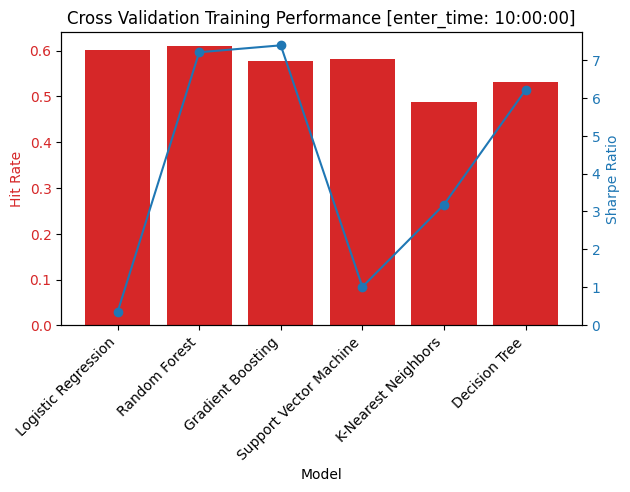

[0.5837550507317949, 0.6063817305677771, 0.5747628026697795, 0.5737670228367903, 0.5328873724222561, 0.5620080213103468] [2.433747200505966, 7.467895782078843, 4.78374868568155, 2.326052059357106, 5.203421228159368, 4.467895782078843]


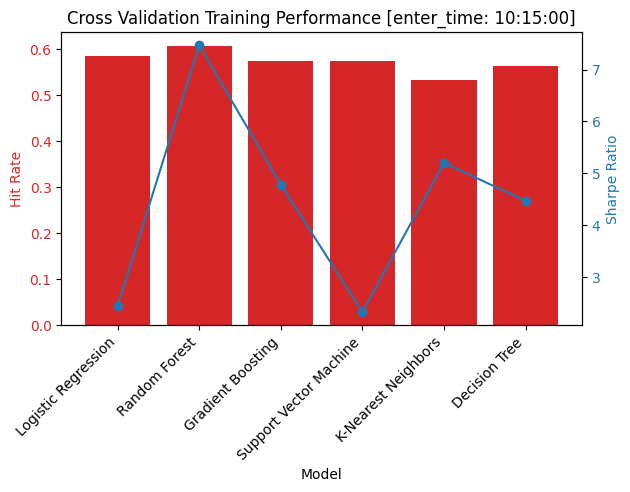

[0.5445422166352399, 0.5886178204782856, 0.5460926042321391, 0.5282661398940469, 0.529050312771243, 0.5697033910987399] [1.862539160123278, 6.51894185998657, 4.040120996605213, 2.54905564213944, 4.49231243462689, 4.51894185998657]


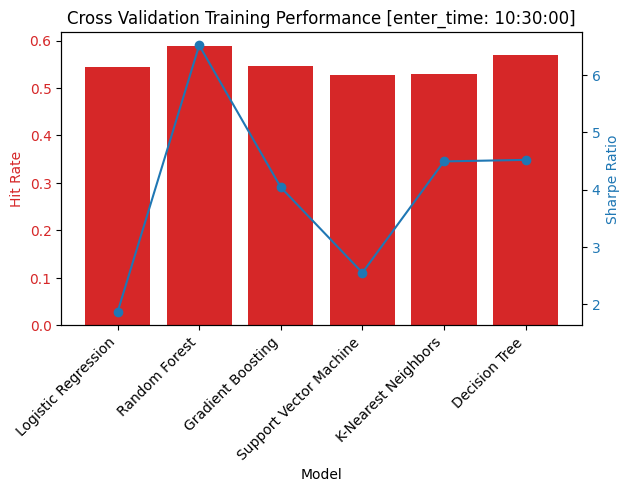

[0.5760270569572896, 0.5670198437640298, 0.553081320523181, 0.5458720181975995, 0.5081350453443477, 0.5243841848493012] [2.545090459258007, 6.582777885283358, 4.64448199688155, 1.9528237937186377, 4.234585913595891, 6.582777885283358]


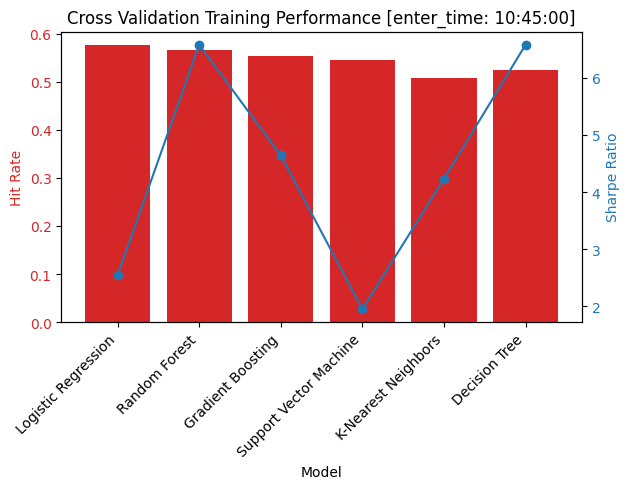

[0.5445422166352399, 0.5786178204782856, 0.5660926042321391, 0.5282661398940469, 0.529050312771243, 0.5097033910987399] [1.9871912308235284, 8.612035518027405, 3.91533341795735, 0.9206353593263061, 3.815356893944309, 4.612035518027405]


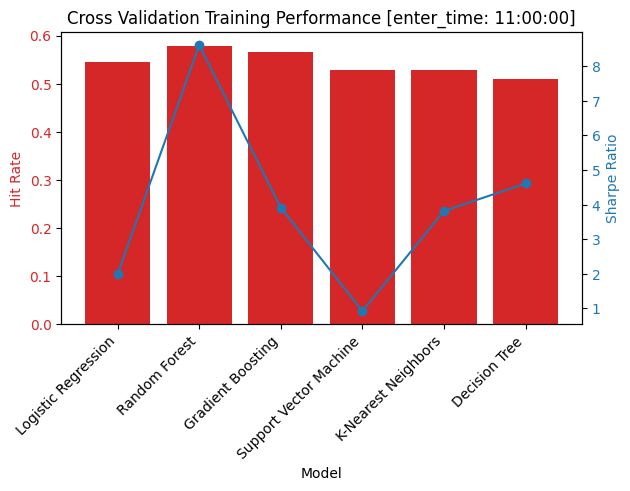

[0.5766651701535424, 0.5983286941426476, 0.5468707910568377, 0.5094968722875696, 0.4794947771691957, 0.5366741492322888] [1.518984266224444, 5.698164027630604, 4.543390163075264, 1.2408886961556151, 4.245768003629077, 4.698164027630604]


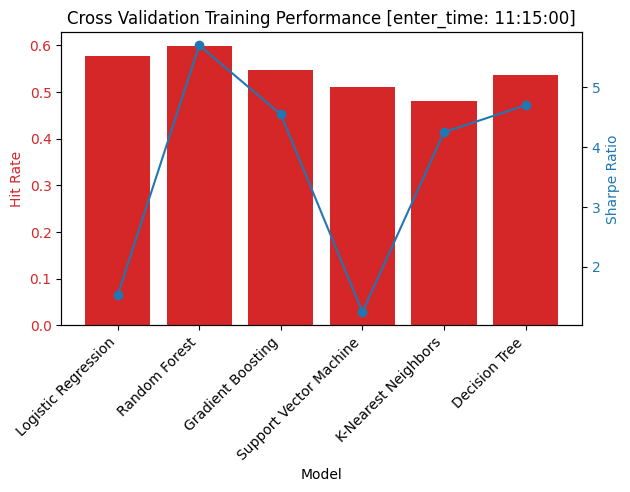

[0.5605441321720391, 0.5622286073448864, 0.5438059321780252, 0.5078399329562121, 0.52903235461375, 0.48802789500463917] [1.59089384020958, 6.078799427046743, 5.649784030936699, 1.569823343345276, 4.991820739536358, 5.078799427046743]


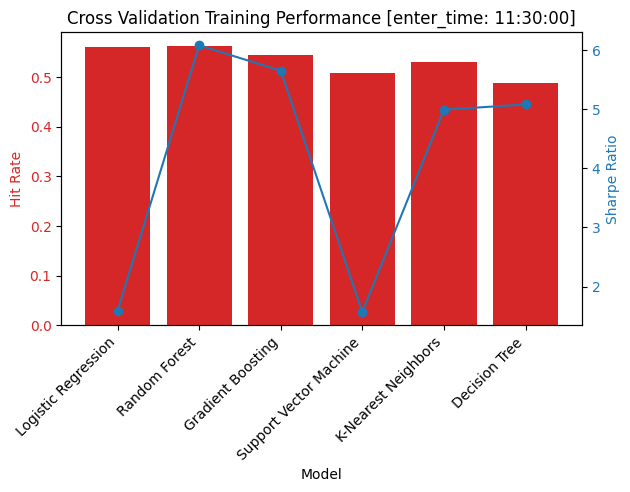

[0.5451117895303942, 0.6530157732483314, 0.5892083445571819, 0.5911493220795546, 0.519011702732633, 0.5950492352817935] [1.352013737335682, 8.035553121381016, 4.9474380672793, 1.762488825697445, 4.451794229243697, 7.035553121381016]


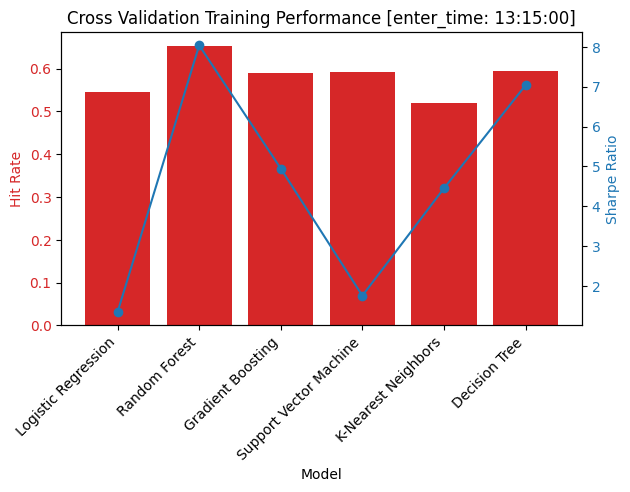

[0.5196019275089042, 0.6067396965071384, 0.5221034988476849, 0.49029062284876235, 0.5127742360300499, 0.4887581934093562] [2.170921900061541, 5.856662654361868, 5.4987552121643, 2.135941917235062, 4.3700822448610195, 4.856662654361868]


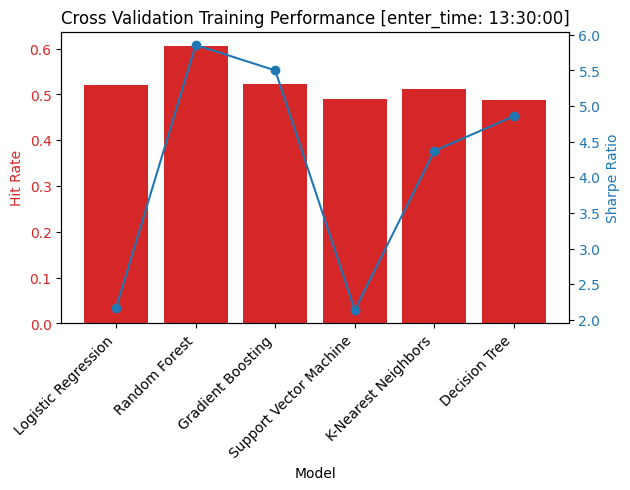

[0.5422256143186377, 0.5821956840561493, 0.5151058034778965, 0.5491754212684445, 0.49572895154290497, 0.5484891203495855] [2.0169684266006156, 5.61359246963603, 4.12496728907188, 1.9985969931089567, 3.8340715437078763, 4.61359246963603]


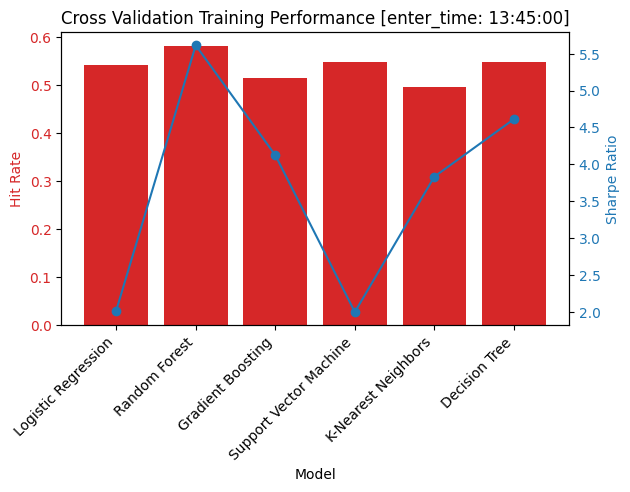

[0.5615575708598965, 0.5818397234443746, 0.5368082368082369, 0.5739486995300949, 0.5096614887312562, 0.5019215228517554] [2.18452055100713, 5.36734074852835, 4.602380347602056, 3.057247802620613, 3.607857449215615, 4.36734074852835]


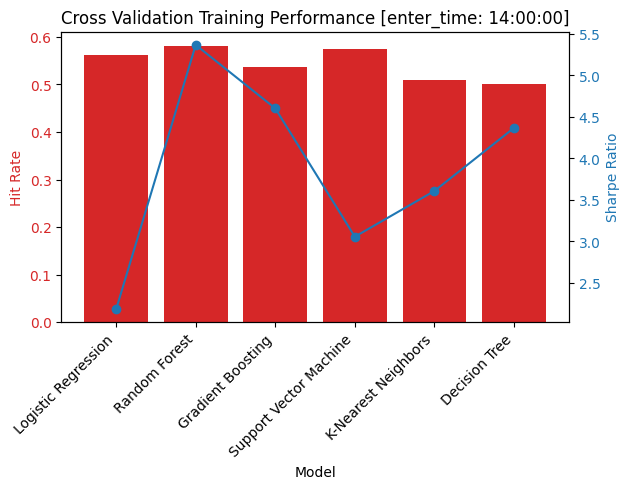

[0.5507168297865973, 0.5751474065427554, 0.5313669150878454, 0.5654514980096376, 0.5390979018885995, 0.52206458950645] [2.1424602712768595, 5.17987526928257, 4.575233828349468, 2.2034030551238213, 4.024343299962424, 1.17987526928257]


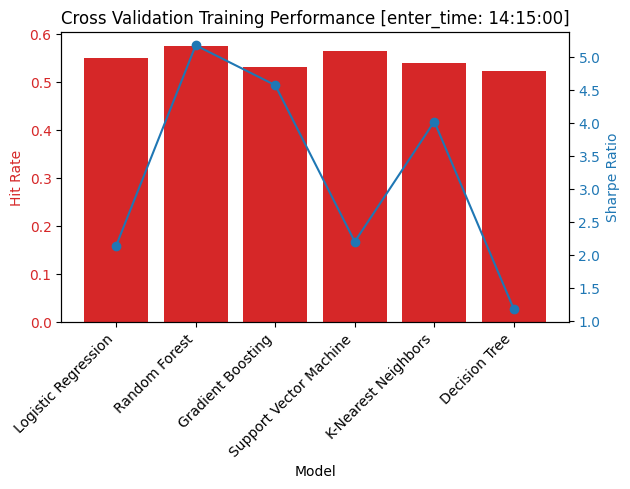

[0.4701325910628237, 0.5273924755320105, 0.4995899554039089, 0.467821974798719, 0.4376133608691748, 0.5030546825895663] [1.258099105741726, 5.595627808975832, 3.9349654136487, 0.7379916245730828, 2.197694186834422, 4.595627808975832]


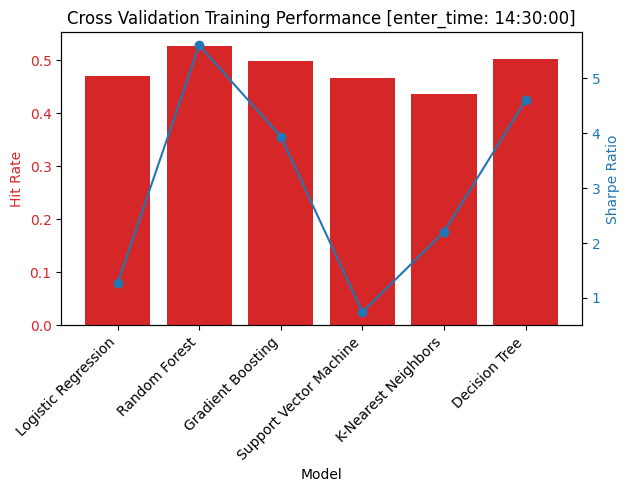

In [ ]:
time_enter_arr = ['10:00:00', '10:15:00', '10:30:00', '10:45:00', '11:00:00',
                  '11:15:00', '11:30:00', '13:15:00', '13:30:00', '13:45:00', '14:00:00', '14:15:00', '14:30:00']
# time_enter_arr = ['13:00:00', '13:15:00', '13:30:00', '13:45:00', '14:00:00', '14:15:00', '14:30:00']
time_exit = '14:45:00'
random_state = 42
models = [
    ('Logistic Regression', LogisticRegression(random_state=random_state)),
    ('Random Forest', RandomForestClassifier(random_state=random_state)),
    ('Gradient Boosting', GradientBoostingClassifier(random_state=random_state)),
    ('Support Vector Machine', SVC(random_state=random_state)),
    ('K-Nearest Neighbors', KNeighborsClassifier()),
    ('Decision Tree', DecisionTreeClassifier(random_state=random_state)),
    ('XGBoost', XGBClassifier(random_state=random_state)),
    ('AdaBoost', AdaBoostClassifier(random_state=random_state))
]
# long_threshold = 0.005
# short_threshold = -0.005
target_threshold = 0.005

for time_enter in time_enter_arr:
    data = get_model_data(close_feature, close_index_feature, sp, time_enter, time_exit, target_threshold)
    X, y = data.drop(columns=['pnl', 'pnl_2', 'Target']), data['Target']

    # y = label_encoder.fit_transform(y)
    # y = pd.Series(y)
    X_train, y_train = X.loc[X.index.strftime('%Y') < '2023'], label_encoder.fit_transform(y.loc[y.index.strftime('%Y') < '2023'])
    X_val, y_val = X.loc[(X.index.strftime('%Y-%m') < '2023-07') & (X.index.strftime('%Y-%m') >= '2023-01')], \
                    label_encoder.fit_transform(y.loc[(y.index.strftime('%Y-%m') < '2023-07') & (y.index.strftime('%Y-%m') >= '2023-01')])
    # X_test, y_test = X.loc[(X.index.strftime('%Y-%m') >= '2023-07')], \
    #                 y.loc[(y.index.strftime('%Y-%m') >= '2023-07')]
    hit_rate = []
    sharpe = []
    for name, model in models:
        hit_rate_train = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1).mean()
        model.fit(X_train, y_train)
        gain_train = data.loc[X_train.index, 'pnl'] * model.predict(X_train)
        gain_val = data.loc[X_val.index, 'pnl'] * model.predict(X_val)
        sharpe_train = gain_train.mean()/gain_train.std() * sqrt(252)
        sharpe_val = gain_val.mean()/gain_val.std() * sqrt(252)
        hit_rate.append(hit_rate_train)
        sharpe.append(np.mean([sharpe_train, sharpe_val]))

    sharpe = pd.Series(sharpe, dtype=object).fillna(0).tolist()
    print(hit_rate, sharpe)
    model_names = [n for n,m in models]
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.set_xlabel('Model')
    ax1.set_ylabel('Hit Rate', color=color)
    ax1.bar(model_names, hit_rate, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Sharpe Ratio', color=color)
    ax2.plot(model_names, sharpe, color=color, marker='o')
    ax2.tick_params(axis='y', labelcolor=color)

    plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')
    fig.tight_layout()
    plt.title(f'Cross Validation Training Performance [enter_time: {time_enter}]')
    plt.show()


# CHOOSING THE BEST TARGET_THRESHOLD

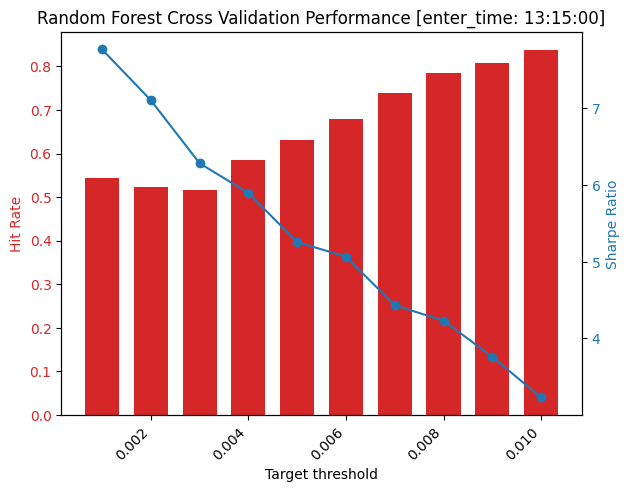

In [ ]:
time_enter_arr = ['10:45:00', '10:15:00',
                  '11:15:00', '11:30:00', '11:45:00']
time_enter = '13:15:00'
time_exit = '14:45:00'

target_thresholds = np.linspace(0.001, 0.01, num=10)
random_state = 42
thresholds = np.linspace(0.001, 0.01, num=10)

# for time_enter in time_enter_arr:
hit_rate = []
sharpe = []
# for target_threshold in target_thresholds:
    # data = get_model_data(close_feature, close_index_feature, sp, time_enter, time_exit, target_threshold)
    # X, y = data.drop(columns=['pnl', 'pnl_2', 'Target']), data['Target']
    # X_train, y_train = X.loc[X.index.strftime('%Y') < '2023'], y.loc[y.index.strftime('%Y') < '2023']
    # X_val, y_val = X.loc[(X.index.strftime('%Y-%m') < '2023-07') & (X.index.strftime('%Y-%m') >= '2023-01')], \
    #                 y.loc[(y.index.strftime('%Y-%m') < '2023-07') & (y.index.strftime('%Y-%m') >= '2023-01')]
    # X_test, y_test = X.loc[(X.index.strftime('%Y-%m') >= '2023-07')], \
    #                 y.loc[(y.index.strftime('%Y-%m') >= '2023-07')]

    # model = RandomForestClassifier(random_state=random_state)
    # hit_rate_train = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1).mean()
    # model.fit(X_train, y_train)
    # gain_train = data.loc[X_train.index, 'pnl'] * model.predict(X_train)
    # sharp_train = gain_train.mean()/gain_train.std() * sqrt(252)
    # hit_rate.append(hit_rate_train)
    # sharpe.append(sharp_train)

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Target threshold')
ax1.set_ylabel('Hit Rate', color=color)
ax1.bar(target_thresholds, hit_rate, color=color, width=0.0007)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Sharpe Ratio', color=color)
ax2.plot(target_thresholds, sharpe, color=color, marker='o')
ax2.tick_params(axis='y', labelcolor=color)

plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')
fig.tight_layout()
plt.title(f'Random Forest Cross Validation Performance [enter_time: {time_enter}]')
plt.show()

Nhận xét xem nên chọn threshold nào?

# FEATURE SELECTION

In [ ]:
time_enter = '11:30:00'
time_exit = '14:45:00'
target_threshold = 0.005

data = get_model_data(close_feature, sp, time_enter, time_exit, target_threshold)
X, y = data.drop(columns=['pnl', 'pnl_2', 'Target']), data['Target']
X_train, y_train = X.loc[X.index.strftime('%Y') < '2023'], y.loc[y.index.strftime('%Y') < '2023']
X_val, y_val = X.loc[(X.index.strftime('%Y-%m') < '2023-07') & (X.index.strftime('%Y-%m') >= '2023-01')], \
                y.loc[(y.index.strftime('%Y-%m') < '2023-07') & (y.index.strftime('%Y-%m') >= '2023-01')]
X_test, y_test = X.loc[(X.index.strftime('%Y-%m') >= '2023-07')], \
                y.loc[(y.index.strftime('%Y-%m') >= '2023-07')]

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif
selector = SelectKBest(score_func=f_classif, k=5)

X_train_selected = selector.fit_transform(X_train, y_train)
X_val_selected = selector.transform(X_val)

rf_classifier = RandomForestClassifier(random_state=42, max_depth=10, min_samples_leaf=2, min_samples_split=10)
rf_classifier.fit(X_train_selected, y_train)

# Predict on the test set
y_pred = rf_classifier.predict(X_val_selected)

# Evaluate the performance
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy with selected features:", accuracy)

Accuracy with selected features: 0.5258620689655172


In [ ]:
rf_classifier = RandomForestClassifier(random_state=42, max_depth=10, min_samples_leaf=2, min_samples_split=10)
rf_classifier.fit(X_train, y_train)
np.sort(rf_classifier.feature_importances_)

array([0.00151133, 0.02734866, 0.02738428, 0.02963776, 0.02986817,
       0.0303115 , 0.03066427, 0.03066444, 0.03154914, 0.03209493,
       0.03305676, 0.03347384, 0.0341436 , 0.03441221, 0.03487416,
       0.03534693, 0.03538213, 0.03587542, 0.03612554, 0.0363199 ,
       0.03673128, 0.03851558, 0.03954067, 0.04073506, 0.04136889,
       0.04172614, 0.04235825, 0.04675459, 0.05222456])

In [ ]:
print(sharpe(data.loc[X_train.index, 'pnl'], rf_classifier.predict(X_train)))
print(sharpe(data.loc[X_val.index, 'pnl'], rf_classifier.predict(X_val)))
print(sharpe(data.loc[X_test.index, 'pnl'], rf_classifier.predict(X_test)))

9.000670034528943
3.195924335941114
1.2634378674329945


# FINE TUNING

In [ ]:
# READ DATA

time_enter = '13:15:00'
time_exit = '14:45:00'
target_threshold = 0.004

data = get_model_data(close_feature, close_index_feature, sp, time_enter, time_exit, target_threshold)
X, y = data.drop(columns=['pnl', 'pnl_2', 'Target']), data['Target']
X_train, y_train = X.loc[X.index.strftime('%Y') < '2023'], y.loc[y.index.strftime('%Y') < '2023']
X_val, y_val = X.loc[(X.index.strftime('%Y-%m') < '2023-07') & (X.index.strftime('%Y-%m') >= '2023-01')], \
                y.loc[(y.index.strftime('%Y-%m') < '2023-07') & (y.index.strftime('%Y-%m') >= '2023-01')]
X_test, y_test = X.loc[(X.index.strftime('%Y-%m') >= '2023-07')], \
                y.loc[(y.index.strftime('%Y-%m') >= '2023-07')]


In [ ]:
# PERFROM GRID SEARCH

random_state = 42
rf_classifier = RandomForestClassifier(random_state=random_state)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [3, 5, 10],
    'min_samples_leaf': [2, 4, 5]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(rf_classifier, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15],
                         'min_samples_leaf': [2, 4, 5],
                         'min_samples_split': [3, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

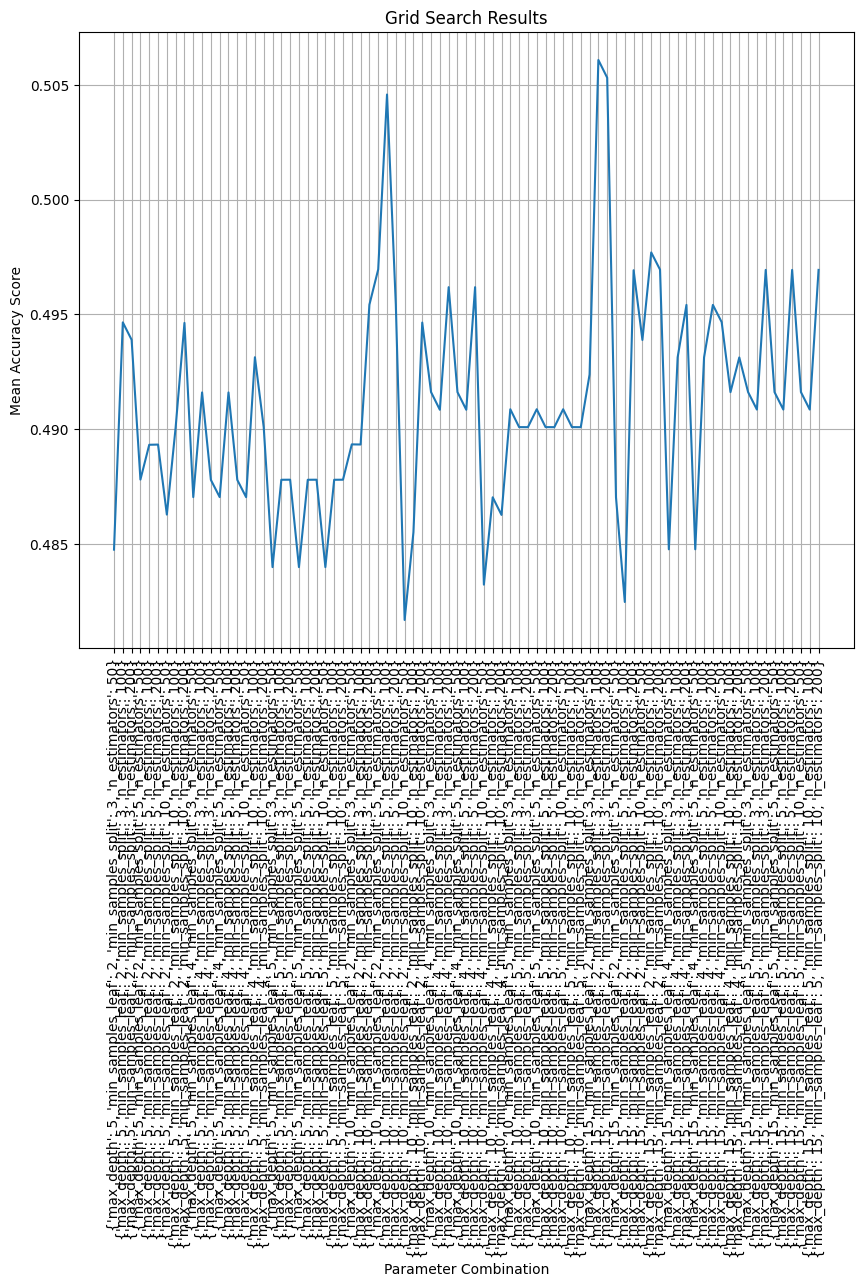

In [ ]:
# Plot grid search results
results = grid_search.cv_results_
params = results['params']
mean_scores = results['mean_test_score']

plt.figure(figsize=(10, 8))
plt.plot(mean_scores)
plt.xlabel('Parameter Combination')
plt.ylabel('Mean Accuracy Score')
plt.title('Grid Search Results')
plt.xticks(np.arange(len(params)), [str(param) for param in params], rotation=90)
plt.grid(True)
plt.show()

In [ ]:
# show best params
grid_search.best_params_

{'max_depth': 15,
 'min_samples_leaf': 2,
 'min_samples_split': 3,
 'n_estimators': 100}

# FITTING BEST PARAMS

In [ ]:
model = RandomForestClassifier(random_state = random_state)
model.set_params(**grid_search.best_params_)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, min_samples_leaf=2, min_samples_split=3,
                       random_state=42)

In [ ]:
print('TRAINNING:\n', accuracy_score(y_train, model.predict(X_train)), sharpe(data.loc[X_train.index, 'pnl'], model.predict(X_train)))
print('vALIDATION:\n', accuracy_score(y_val, model.predict(X_val)), sharpe(data.loc[X_val.index, 'pnl'], model.predict(X_val)))
print('TEST:\n', accuracy_score(y_test, model.predict(X_test)), sharpe(data.loc[X_test.index, 'pnl'], model.predict(X_test)))

TRAINNING:
 0.9863013698630136 11.999984261083346
vALIDATION:
 0.48739495798319327 1.7376656119653113
TEST:
 0.48466257668711654 0.3588805321331199


In [ ]:
sharpe(data.loc[X_train.index, 'pnl'], model.predict(X_train))

11.999984261083346

In [ ]:
def sharpe(pnl, position):
    gain = np.multiply(pnl, position)
    return (gain.mean()/gain.std()) * sqrt(252)
sharpe(np.array([1,2]), np.array([3,4]))

34.9239173060526

In [ ]:
fix time_enter, model, target_threshold
chạy cv trên tập train, validate trên tập test
loop chọn model, chọn time enter, chọn target_threshold => fine tune các tham số của mô hình

# ADD SENTIMENT FEATURE

In [ ]:
# read data
_, news = read_data(news=True)

# READ DATA

time_enter = '11:30:00'
time_exit = '14:45:00'
long_threshold = 0.005
short_threshold = -0.005

data = get_model_data(close_feature, sp, time_enter, time_exit, long_threshold, short_threshold)
X, y = data.drop(columns=['pnl', 'pnl_2', 'Target']), data['Target']

# add sentiment

news_resampled = pd.DataFrame(news).resample('1D')['result'].mean().dropna()
X = pd.merge(X, pd.DataFrame(news_resampled), left_index=True, right_index=True, how='left').fillna(-10)

X_train, y_train = X.loc[X.index.strftime('%Y') < '2023'], y.loc[y.index.strftime('%Y') < '2023']
X_val, y_val = X.loc[(X.index.strftime('%Y-%m') < '2023-07') & (X.index.strftime('%Y-%m') >= '2023-01')], \
                y.loc[(y.index.strftime('%Y-%m') < '2023-07') & (y.index.strftime('%Y-%m') >= '2023-01')]
X_test, y_test = X.loc[(X.index.strftime('%Y-%m') >= '2023-07')], \
                y.loc[(y.index.strftime('%Y-%m') >= '2023-07')]


In [ ]:
# fitting

model = RandomForestClassifier(random_state = random_state, max_depth=10, min_samples_leaf=2, min_samples_split=10)
# model.set_params(**grid_search.best_params_)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=10,
                       random_state=42)

In [ ]:
print(accuracy_score(y_train, model.predict(X_train)), sharpe(data.loc[X_train.index, 'pnl'], model.predict(X_train)))
print(accuracy_score(y_val, model.predict(X_val)), sharpe(data.loc[X_val.index, 'pnl'], model.predict(X_val)))
print(accuracy_score(y_test, model.predict(X_test)), sharpe(data.loc[X_test.index, 'pnl'], model.predict(X_test)))

0.8505034856700232 9.269673445094009
0.5172413793103449 0.643002871536857
0.5534591194968553 0.4094285395012563
